In [25]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [26]:
writer = SummaryWriter(log_dir="../runs/char_rnn")
writer.add_text("alphabet", ALL_LETTERS)
device = torch.device("mps")
device

device(type='mps')

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [28]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)
writer.add_graph(rnn, input_to_model=(letter_to_tensor("A"), rnn.init_hidden()))

# One step
input_tensor = letter_to_tensor("A")
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor)
output.size(), next_hidden.size()

(torch.Size([1, 18]), torch.Size([1, 128]))

In [29]:
# Whole sequence/name/line
input_tensor = line_to_tensor("Albert")
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
output.size(), next_hidden.size()

(torch.Size([1, 18]), torch.Size([1, 128]))

In [30]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]


category_from_output(output)

'Czech'

In [31]:
criteria = nn.NLLLoss()  # Negative Log Likelihood Loss
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [32]:
def train(line_tensor: torch.Tensor, category_tensor: torch.Tensor) -> tuple:
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criteria(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [33]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(
        category_lines, all_categories
    )
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    writer.add_scalar("loss", loss, i)

    if (i + 1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i + 1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i} {i / n_iters * 100} {loss:.4f} {line} / {guess} {correct}")

4999 4.999 0.7736 Protopsaltis / Greek CORRECT
9999 9.998999999999999 2.0802 Aller / German WRONG (Dutch)
14999 14.999 2.2047 Abano / Italian WRONG (Spanish)
19999 19.999 3.7430 Botros / Greek WRONG (Arabic)
24999 24.999 1.0852 Maclean / Scottish CORRECT
29999 29.999 1.7998 Raskoph / German CORRECT
34999 34.999 0.5113 Chijov / Russian CORRECT
39999 39.999 2.6085 Frei / Spanish WRONG (German)
44999 44.999 1.5400 Won / Korean WRONG (Chinese)
49999 49.999 0.7438 Nie / Chinese CORRECT
54999 54.998999999999995 2.2599 Siekert / Dutch WRONG (German)
59999 59.999 0.2723 Doan / Vietnamese CORRECT
64999 64.999 0.5488 Mccallum / Scottish CORRECT
69999 69.999 0.7356 Murray / Scottish CORRECT
74999 74.99900000000001 0.4215 Martinez / Spanish CORRECT
79999 79.999 0.5983 Oppenheimer / German CORRECT
84999 84.999 3.1757 Hoffmann / Scottish WRONG (German)
89999 89.999 0.5131 Hazov / Russian CORRECT
94999 94.999 0.0423 Missiakos / Greek CORRECT
99999 99.99900000000001 1.5615 Ding / Vietnamese WRONG (Chi

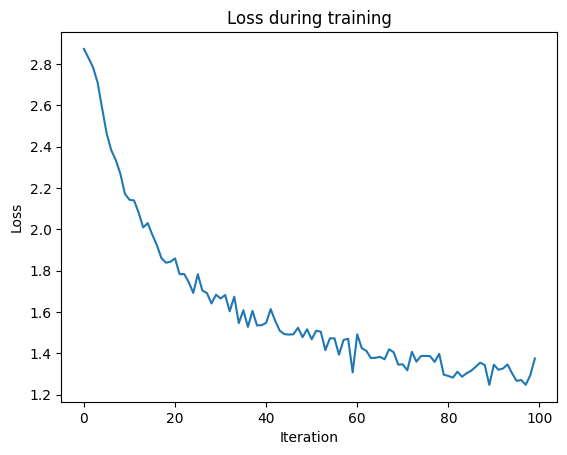

In [34]:
plt.figure()
plt.plot(all_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.show()

In [35]:
def predict(input_line: str):
    print(f"\n> {input_line}")
    with torch.inference_mode():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)


predict("Tran")


> Tran
Vietnamese


In [36]:
# Hyperparameters
# input_size = 784  # 28x28
hidden_size = 128
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
num_layers = 2

In [37]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="../data", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

test_dataset = torchvision.datasets.MNIST(
    root="../data", train=False, transform=transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

In [67]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN2, self).__init__()
        # Input size = 28 -> 28 pixels in each row
        self.hidden_size = hidden_size  # 128 neurons in hidden layer
        self.num_layers = num_layers  # 2 layers in RNN
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x -> (batch_size, seq, input_size) -> (100, 28, 28)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # h0 -> (num_layers, batch, hidden_size) -> (2, 100, 128) -> 2 tensors of 100x128 each. 100 rows and 128 columns
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            device
        )  # Cell state for LSTM
        # out, _ = self.rnn(x, h0)
        # out, _ = self.gru(x, h0)
        out, _ = self.lstm(x, (h0, c0))
        # out: (batch_size, seq_length, hidden_size)
        # out (100, 28, 128)
        out = out[:, -1, :]  # (100, 128)
        out = self.fc(out)
        return out

In [68]:
rnn2 = RNN2(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn2.parameters(), lr=learning_rate)

# Train the model
rnn2.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Original shape: [100, 1, 28, 28]: 100 images, 1 channel, 28x28 -> [100, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = rnn2(images)
        loss = criteria(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{n_total_steps}, Loss = {loss.item():.4f}"
            )

Epoch 1/2, Step 100/600, Loss = 0.7211
Epoch 1/2, Step 200/600, Loss = 0.4394
Epoch 1/2, Step 300/600, Loss = 0.2652
Epoch 1/2, Step 400/600, Loss = 0.2366
Epoch 1/2, Step 500/600, Loss = 0.3062
Epoch 1/2, Step 600/600, Loss = 0.2429
Epoch 2/2, Step 100/600, Loss = 0.0942
Epoch 2/2, Step 200/600, Loss = 0.0376
Epoch 2/2, Step 300/600, Loss = 0.1640
Epoch 2/2, Step 400/600, Loss = 0.0634
Epoch 2/2, Step 500/600, Loss = 0.1077
Epoch 2/2, Step 600/600, Loss = 0.1335


In [73]:
from torchinfo import summary

# Make sure to set the device to cuda
sample = torch.rand(1, 28, 28).to(device)
writer.add_graph(rnn2, input_to_model=sample)
writer.close()
summary(rnn2, input_data=sample)

Layer (type:depth-idx)                   Output Shape              Param #
RNN2                                     [1, 10]                   212,992
├─LSTM: 1-1                              [1, 28, 128]              212,992
├─Linear: 1-2                            [1, 10]                   1,290
Total params: 427,274
Trainable params: 427,274
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.97
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.86
Estimated Total Size (MB): 0.89

In [70]:
# Test the model
rnn2.eval()
with torch.inference_mode():
    n_correct = 0
    n_samples = 0

    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = rnn2(images)

        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy = {acc}")

Accuracy = 97.46
